# Time Series Analysis II

In the first lecture, we are mainly concerned with how to model and evaluate time series data.

References

- [Statistical forecasting: notes on regression and time series analysis](https://people.duke.edu/~rnau/411home.htm)
- [Time Series Analysis (TSA) in Python - Linear Models to GARCH](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016)

Some Python packages for Time Series modeling

- [`tslearn`](https://github.com/rtavenar/tslearn)
- [`traces`](https://github.com/datascopeanalytics/traces)
- [`prophet`](https://github.com/facebook/prophet)
- [`statsmodels`](https://github.com/facebook/prophet)
- [`cesium`](https://github.com/cesium-ml/cesium)
- [`pyflux`](https://github.com/RJT1990/pyflux)

In [1]:
import warnings
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', RuntimeWarning)

## Stationarity

A stationary process is a time series whose mean, variance and auto-covariance do not change over time. Often, transformations can be applied to convert a non-stationary process to a stationary one. Periodicity (seasonality) is another form of non-stationarity that must be accounted for in the modeling.

## Example

In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('data/uk-deaths-from-bronchitis-emphys.csv')

In [4]:
df.head(3)

,Month,"U.K. deaths from bronchitis, emphysema and asthma"
0,1974-01,3035
1,1974-02,2552
2,1974-03,2704


In [5]:
df.tail(3)

,Month,"U.K. deaths from bronchitis, emphysema and asthma"
70,1979-11,1781
71,1979-12,1915
72,U.K. deaths from bronchitis,emphysema and asthma


In [6]:
df = df.iloc[:-1, :]

In [7]:
df.columns = ['ds', 'y']

In [8]:
df['y'] = df['y'].astype('int')

In [9]:
index = pd.to_datetime(df['ds'], format='%Y-%m').copy()

In [10]:
df.index = index

In [11]:
df.index.freq = 'MS'

In [12]:
df.drop('ds', axis=1, inplace=True)

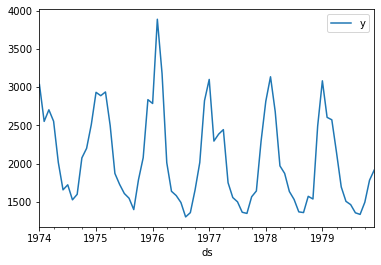

In [13]:
df.plot()
pass

### Mean

In [14]:
import matplotlib.pyplot as plt

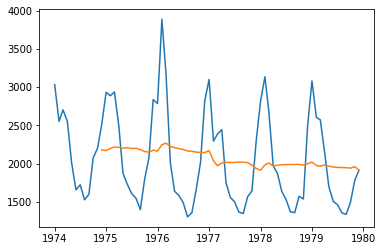

In [15]:
plt.plot(df)
plt.plot(df.rolling(window=12).mean())
pass

### De-trending

We can make the mean stationary by subtracting the trend.

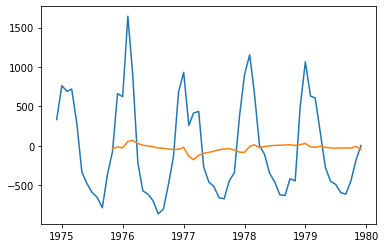

In [16]:
df1 = df - df.rolling(window=12).mean()
plt.plot(df1)
plt.plot(df1.rolling(window=12).mean())
pass

### Variance

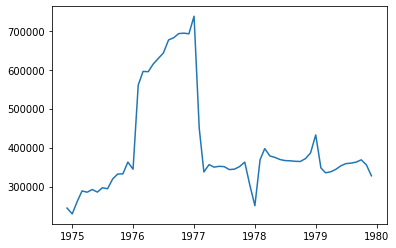

In [17]:
plt.plot(df.rolling(window=12).var())
pass

### Variance stabilizing transform

It is common to apply a simple variance stabilizing transform, especially if the variance depends on the mean.

In [18]:
df2 = df.copy()
df2['y'] = np.log(df['y'])

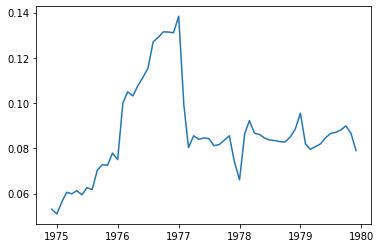

In [19]:
plt.plot(df2.rolling(window=12).var())
pass

### Periodicity

A simple way to remove periodicity is by differencing. For intuition, consider the simple harmonic oscillator.

$$
\frac{d^2x}{dt^2} = - \omega^2 x
$$

If we look at the second derivative, it is a constant with respect to time (and hence stationary). Differencing twice is a finite approximation to the second derivative, and achieves a similar effect of reducing oscillations.

In [20]:
from scipy.integrate import odeint

In [21]:
def f(x, t, ω2):
    y, ydot = x
    return [ydot, -ω2 * y]

In [22]:
y0 = np.array([0,1])
ts = np.linspace(0, 20, 100)
ω2 = 1

xs = odeint(f, y0, ts, args=(ω2,))

In [23]:
x = pd.Series(xs[:, 1]) # displacement over time

In [24]:
x1 = x - x.shift()
x2 = x1 - x1.shift()

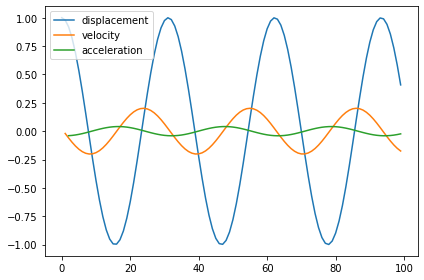

In [25]:
plt.plot(x, label='displacement')
plt.plot(x1, label='velocity')
plt.plot(x2, label='acceleration')
plt.legend()
plt.tight_layout()

### Auto-correlation

The auto-correlation function plots the Pearson correlation between a time series and a lagged version of the same time series.

In [26]:
[pd.Series.corr(df.y, df.y.shift(i)) for i in range(24)][:3]

[0.9999999999999998, 0.769695884934395, 0.40766948927949737]

For convenience there is also an `autocorr` function

In [27]:
ac = [df.y.autocorr(i) for i in range(24)]    

In [28]:
ac[:3]

[0.9999999999999998, 0.769695884934395, 0.40766948927949737]

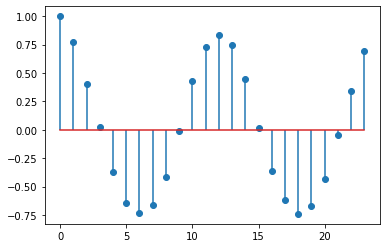

In [29]:
plt.stem(ac)
pass

In [30]:
from pandas.plotting import autocorrelation_plot

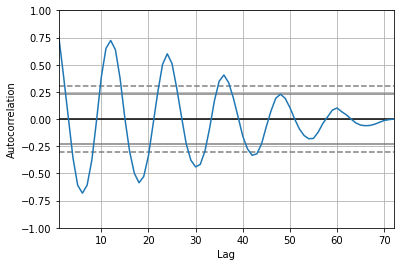

In [31]:
autocorrelation_plot(df.y)
pass

In [32]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

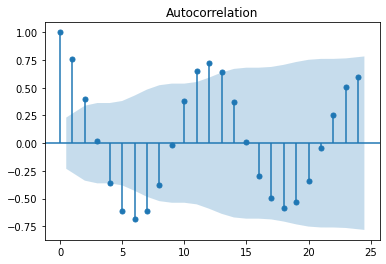

In [33]:
plot_acf(df.y, lags=24)
pass

### Partial auto-correlation

The partial auto-correlation at lag $k$ is a conditional correlation, and measures the correlation that remains after taking into account the correlations at lags smaller than $k$. For an analogy, consider the regressions

$y = \beta_0 + \beta_2 x^2$

where $\beta_2$ measures the dependency between $y$ and $x^2$

and

$y = \beta_0 + \beta_1 x + \beta_2 x^2$

where $\beta_2$ measures the dependency between $y$ and $x^2$ after accounting for the dependency between $y$ and $x$.

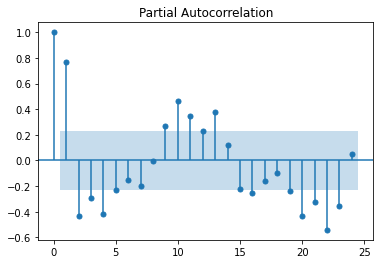

In [34]:
plot_pacf(df.y, lags=24)
pass

## Decomposing a model

The simplest models generally decompose the time series into one or more seasonality effects, a trend and the residuals.

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

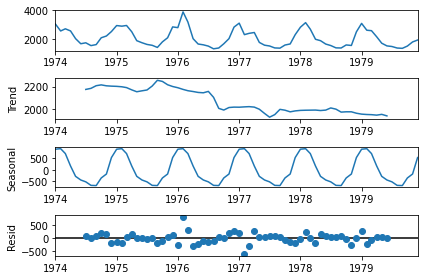

In [36]:
m1 = seasonal_decompose(df)
m1.plot()
pass

In [37]:
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)

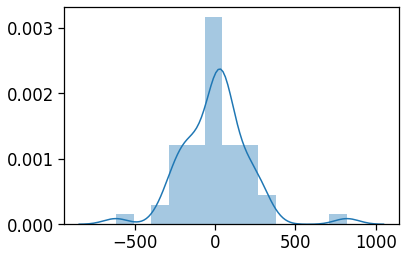

In [38]:
sns.distplot(m1.resid.dropna().values.squeeze())
pass

## Classical models for time series

### White noise

White noise refers to a time series that is independent and identically distributed (IID) with expectation equal to zero.

In [39]:
def plot_ts(ts, lags=None):
    fig = plt.figure(figsize = (8, 8))
    ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((2, 2), (1, 0))
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    
    ax1.plot(ts)
    ax1.plot(ts.rolling(window=lags).mean())
    plot_acf(ts, ax=ax2, lags=lags)
    plot_pacf(ts, ax=ax3, lags=lags)
    
    plt.tight_layout()
    return fig

In [40]:
np.random.seed(123)
w = pd.Series(np.random.normal(0, 1, 100))

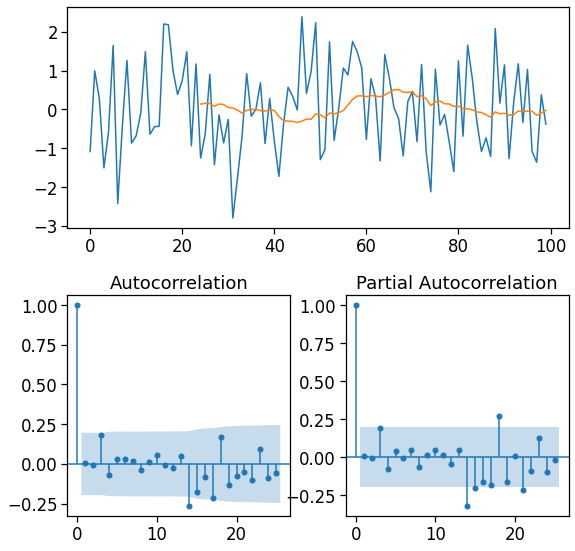

In [41]:
plot_ts(w, lags=25)
pass

### Random walk

A random walk has the following form

$$
x_t = x_{t-1} + \omega_t
$$

Note that a random walk is not stationary, since there is a time dependence. 

#### Simulate a random walk

In [42]:
n = 100
x = np.zeros(n)
w = np.random.normal(0, 1, n)

for t in range(n):
    x[t] = x[t-1] + w[t]
    
x = pd.Series(x)

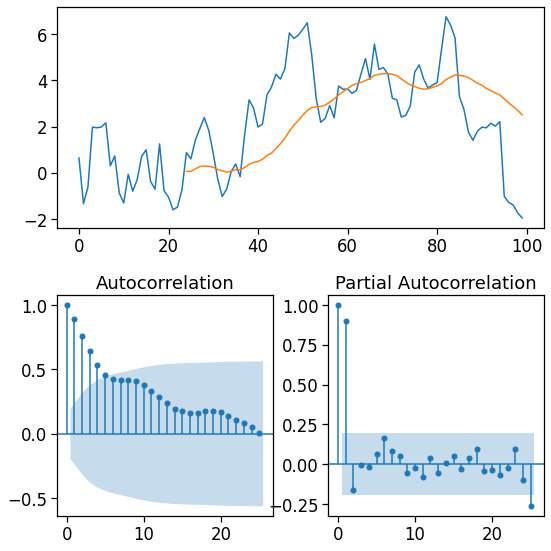

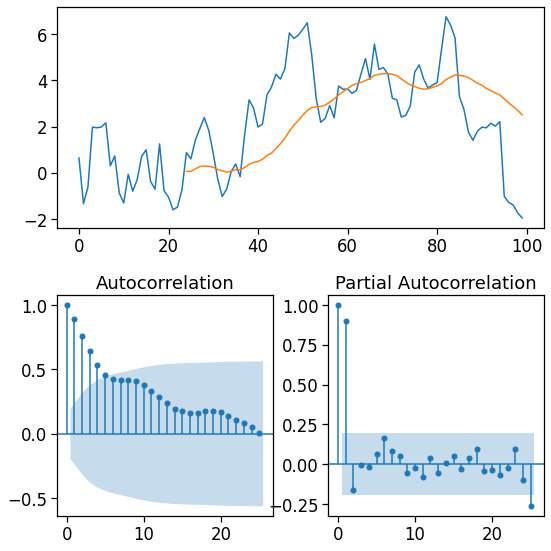

In [43]:
plot_ts(x, lags=25)

#### Effect of differencing on random walk

Differencing converts a random walk into a white noise process.

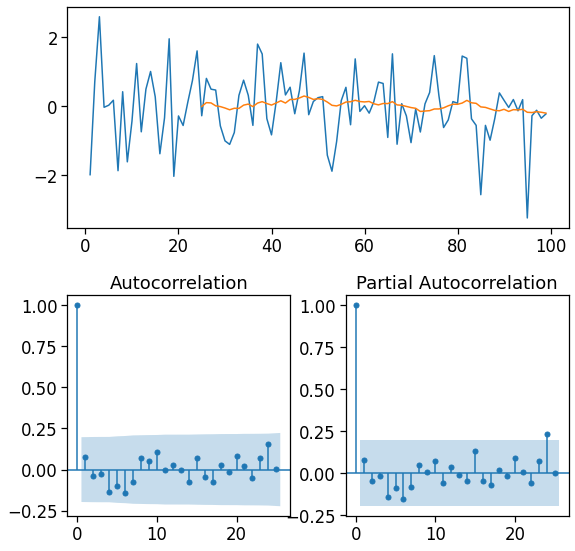

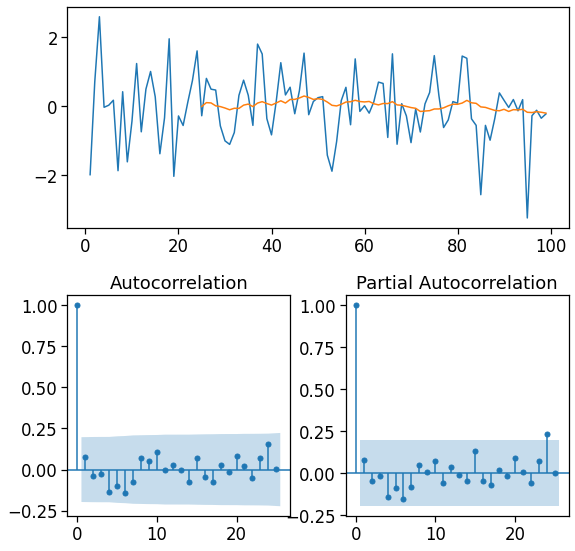

In [44]:
x1 = x - x.shift()
plot_ts(x1.dropna(), lags=25)

### Auto-regressive models of order $p$ AR($p$)

An AR model of order $p$ has the following form

$$
x_t = \sum_{i=1}^p \alpha_i x_{t-i} + \omega_t
$$

where $\omega$ is a white noise term. 

The time series is modeled as a linear combination of past observations.

#### Simulate an AR(1) 

In [45]:
np.random.seed(123)
n = 300

α = 0.6
x = np.zeros(n)
w = np.random.normal(0, 1, n)

for t in range(n):
    x[t] = α*x[t-1] + w[t]
    
x = pd.Series(x)

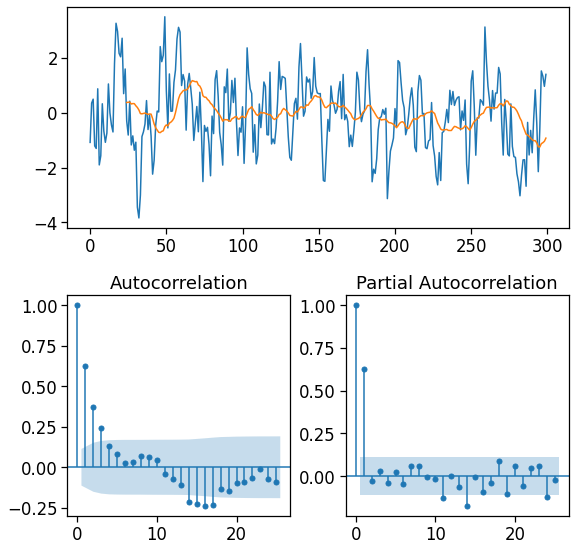

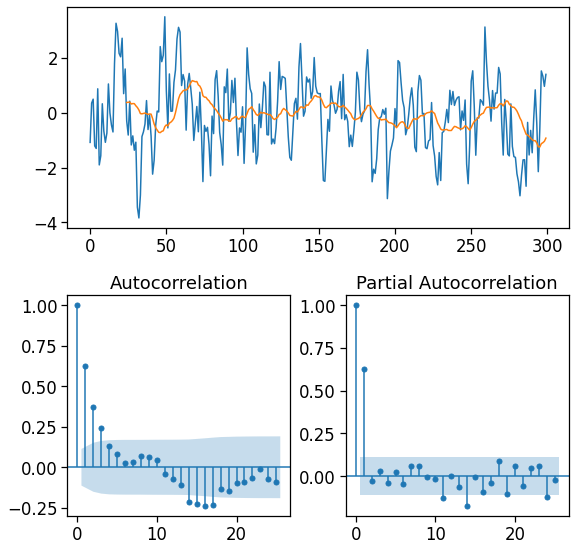

In [46]:
plot_ts(x, lags=25)

Note that a reasonable estimate of $p$ is the largest lag where the partial autocorrelation falls outside the 95% confidence interval. Here it is 1.

#### Fitting an AR model

In [47]:
from statsmodels.tsa.ar_model import AR

In [48]:
m2 = AR(x)

In [49]:
m2.select_order(maxlag=25, ic='aic')

1

In [50]:
m2 = m2.fit(maxlag=25, ic='aic')

Compare estimated slope with true slope (=0)

In [51]:
m2.params[0]

-0.023342103477991587

Compare estimated $\alpha$ with treu $\alpha$ (=0.6)

In [52]:
m2.params[1]

0.6272271957584277

#### Simulate an AR(3) process

In [53]:
from statsmodels.tsa.api import arma_generate_sample

In [54]:
np.random.seed(123)

ar = np.array([1, -0.3, 0.4, -0.3])
ma = np.array([1, 0])

x = arma_generate_sample(ar=ar, ma=ma, nsample=100)
x = pd.Series(x)

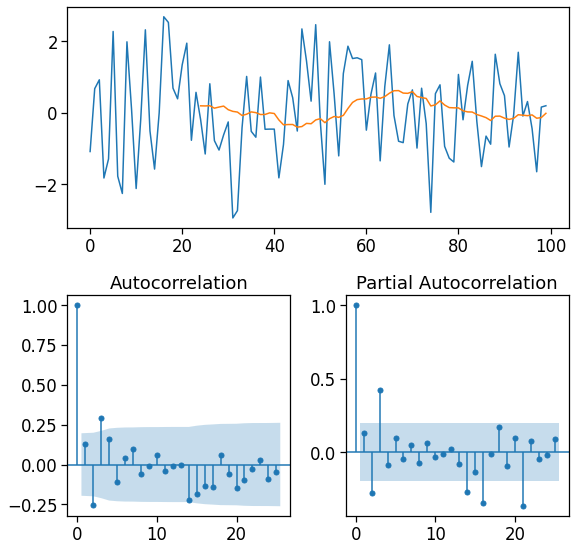

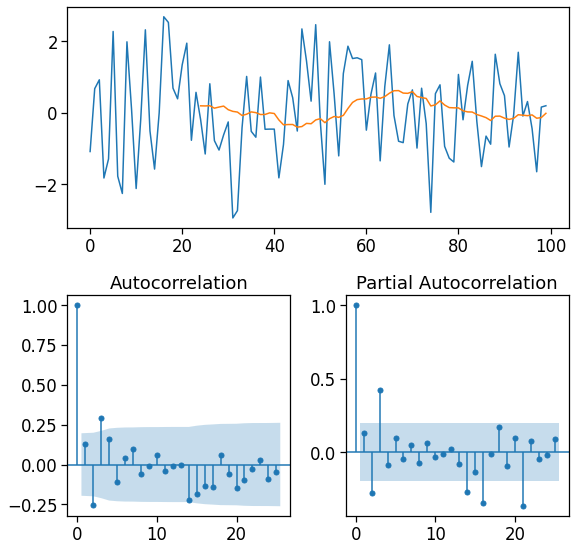

In [55]:
plot_ts(x, lags=25)

Note that a reasonable estimate of $p$ is the largest lag where the partial autocorrelation consistently falls outside the 95% confidence interval. Here it is 3

#### Fitting an AR model

In [56]:
from statsmodels.tools.sm_exceptions import HessianInversionWarning, ConvergenceWarning
import warnings
warnings.simplefilter('ignore', HessianInversionWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [57]:
m3 = AR(x)
m3.select_order(maxlag=25, ic='aic')

3

In [58]:
m3 = m3.fit(maxlag=25, ic='aic')

Compare with true coefficients (0.3, -0.4, 0.3)

In [59]:
m3.params[1:4]

L1.y    0.280252
L2.y   -0.331188
L3.y    0.473796
dtype: float64

## Moving Average models MA(q)

A moving average model of order $q$ is

$$
x_t = \sum_{i=1}^{q} \beta_i w_{t-i} + w_t
$$

The time series is modeled as a linear combination of past white noise terms.

#### Simulate MA(3) 

In [60]:
ar = np.array([1, 0])
ma = np.array([1, 0.3, 0.4, 0.7])

x = arma_generate_sample(ar=ar, ma=ma, nsample=100)
x = pd.Series(x)

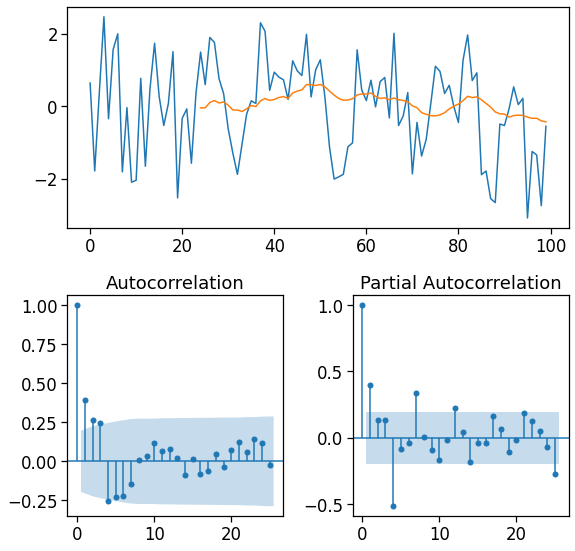

In [61]:
plot_ts(x, lags=25)
pass

Note that a reasonable estimate of $q$ is the largest lag where the autocorrelation falls outside the 95% confidence interval. Here it is probably between 3 and 5.

#### Fit an MA model

In [62]:
from statsmodels.tsa.arima_model import ARMA

In [63]:
p = 0
q = 3
m4 = ARMA(x, order=(p, q))
m4 = m4.fit(maxlag=25, method='mle')

Compare with true coefficients (0.3, 0.4, 0.7)

In [64]:
m4.params[1:4]

ma.L1.y    0.294910
ma.L2.y    0.388307
ma.L3.y    0.777256
dtype: float64

In [65]:
m4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: ARMA
==================================================================
Model:              ARMA             BIC:                 298.3503
Dependent Variable: y                Log-Likelihood:      -137.66 
Date:               2020-11-08 19:24 Scale:               1.0000  
No. Observations:   100              Method:              mle     
Df Model:           4                Sample:              0       
Df Residuals:       96                                    0       
Converged:          1.0000           S.D. of innovations: 0.944   
No. Iterations:     16.0000          HQIC:                290.596 
AIC:                285.3244                                      
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const       -0.0578     0.2291   -0.2524   0.8007   -0.5068   0.3911
ma.L1.y      0.2949     0.0758    3.8893   0.0001    0.1463   0.4435
ma.L2.y      0.3883     0.0588    6.6066   0.0000    0.2731   0.5035
ma.L3.y      0.7773     0.0715   10.8704   0.0000    0.6371   0.9174
--------------------------------------------------------------------------
                 Real          Imaginary         Modulus         Frequency
--------------------------------------------------------------------------
MA.1            0.3236           -1.0085          1.0592           -0.2006
MA.2            0.3236            1.0085          1.0592            0.2006
MA.3           -1.1469           -0.0000          1.1469           -0.5000
==================================================================

"""

## ARMA(p, q)

As you might have suspected, we can combine the AR and MA models to get an ARMA model. The ARMA model takes the form

$$
x_t = \sum_{i=1}^{p} \alpha_i x_{t-i} + \sum_{i=1}^{q} \beta_i w_{t-i} + w_t
$$

In [66]:
np.random.seed(123)

ar = np.array([1, -0.3, 0.4, -0.3])
ma = np.array([1, 0.3, 0.4, 0.7])

x = arma_generate_sample(ar=ar, ma=ma, nsample=100)
x = pd.Series(x)

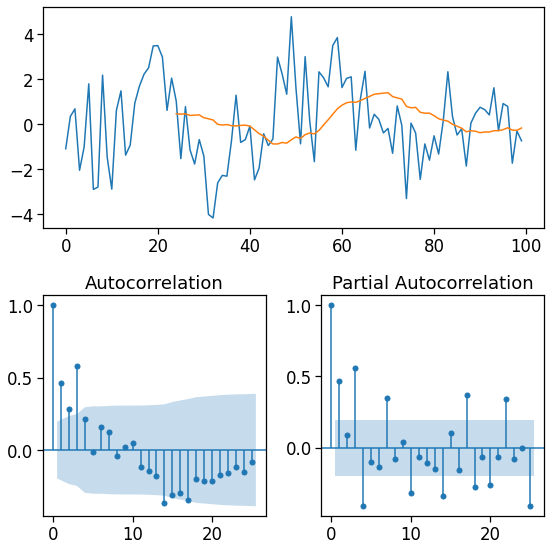

In [67]:
plot_ts(x, lags=25)
pass

In [68]:
p = 3
q = 3
m5 = ARMA(x, order=(p, q))
m5 = m5.fit(maxlag=25, method='mle')

In [69]:
m5.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: ARMA
==================================================================
Model:              ARMA             BIC:                 340.6230
Dependent Variable: y                Log-Likelihood:      -151.89 
Date:               2020-11-08 19:24 Scale:               1.0000  
No. Observations:   100              Method:              mle     
Df Model:           7                Sample:              0       
Df Residuals:       93                                    0       
Converged:          1.0000           S.D. of innovations: 1.056   
No. Iterations:     125.0000         HQIC:                328.217 
AIC:                319.7816                                      
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const       0.0717     0.3634    0.1973   0.8436   -0.6405    0.7839
ar.L1.y     0.2683     0.0988    2.7163   0.0066    0.0747    0.4619
ar.L2.y    -0.3601     0.0947   -3.8014   0.0001   -0.5458   -0.1745
ar.L3.y     0.3255     0.0971    3.3521   0.0008    0.1352    0.5158
ma.L1.y     0.3178     0.0519    6.1217   0.0000    0.2161    0.4196
ma.L2.y     0.4743     0.0576    8.2372   0.0000    0.3615    0.5872
ma.L3.y     0.9010     0.0676   13.3322   0.0000    0.7686    1.0335
--------------------------------------------------------------------------
                 Real          Imaginary         Modulus         Frequency
--------------------------------------------------------------------------
AR.1           -0.2929           -1.3152          1.3475           -0.2849
AR.2           -0.2929            1.3152          1.3475            0.2849
AR.3            1.6923           -0.0000          1.6923           -0.0000
MA.1            0.2917           -0.9566          1.0000           -0.2029
MA.2            0.2917            0.9566          1.0000            0.2029
MA.3           -1.1098           -0.0000          1.1098           -0.5000
==================================================================

"""

#### Estimating order

We can loop through a range of orders (inspect the ACF and PACF plots) to choose the order for the AR model.

In [70]:
best_aic = np.infty

for p in np.arange(5):
    for q in np.arange(5):
        try:
            # We assume that the data has been detrended
            m_ = ARMA(x, order=(p, q)).fit(method='mle', trend='nc') 
            aic_ = m_.aic
            if aic_ < best_aic:
                best_aic = aic_
                best_order = (p, q)
                best_m = m_
        except:
            pass

In [71]:
best_order

(3, 3)

### ARIMA(p, d, q)

The ARIMA model adds differencing to convert a non-stationary model to stationarity. The parameter $d$ is the number of differencings to perform.

In [72]:
from statsmodels.tsa.arima_model import ARIMA

In [73]:
best_aic = np.infty

for p in np.arange(5):
    for d in np.arange(3):
        for q in np.arange(5):
            try:
                # We assume that the data has been detrended
                m_ = ARIMA(x, order=(p, d, q)).fit(method='mle', trend='nc') 
                aic_ = m_.aic
                if aic_ < best_aic:
                    best_aic = aic_
                    best_order = (p, d, q)
                    best_m = m_
            except:
                pass

In [74]:
best_order

(3, 0, 3)

### ARMA on UK disease data

In [75]:
df.head()

,y
ds,
1974-01-01,3035
1974-02-01,2552
1974-03-01,2704
1974-04-01,2554
1974-05-01,2014


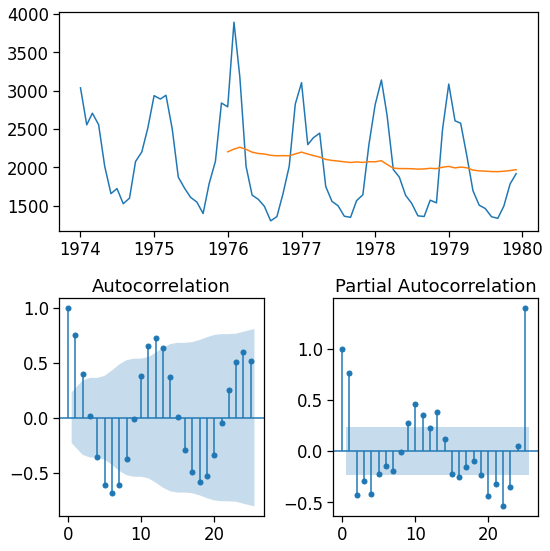

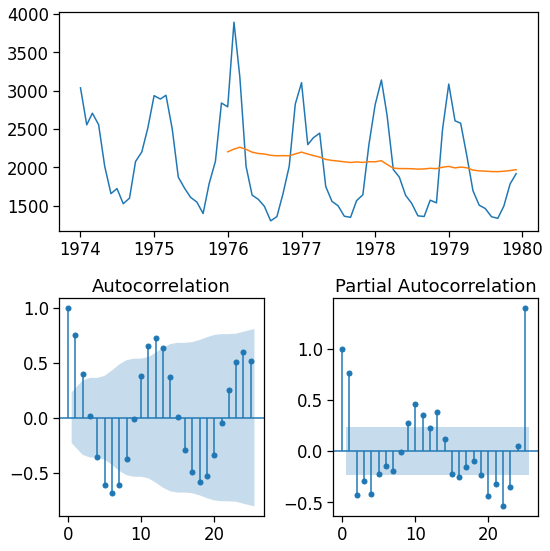

In [76]:
plot_ts(df, lags=25)

In [77]:
best_aic = np.infty

for p in np.arange(5, 10):
    for q in np.arange(5, 10):
        try:
            m_ = ARMA(df, order=(p, q)).fit(method='mle')
            aic_ = m_.aic
            if aic_ < best_aic:
                best_aic = aic_
                best_order = (p, q)
                best_m = m_
        except:
            pass

In [78]:
best_order

(7, 5)

#### Fit ARMA model

In [79]:
m6 = ARMA(df, order=best_order)
m6 = m6.fit(maxlag=25, method='mle')

In [80]:
m6.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 1063.5353 
Dependent Variable: y                Log-Likelihood:      -501.83   
Date:               2020-11-08 19:25 Scale:               1.0000    
No. Observations:   72               Method:              mle       
Df Model:           13               Sample:              01-01-1974
Df Residuals:       59                                    12-01-1979
Converged:          1.0000           S.D. of innovations: 236.267   
No. Iterations:     111.0000         HQIC:                1044.351  
AIC:                1031.6620                                       
--------------------------------------------------------------------
             Coef.   Std.Err.      t      P>|t|    [0.025    0.975] 
--------------------------------------------------------------------
const      2056.6432  36.6279     56.1496 0.0000 1984.8537 2128.4326
ar.L1.y       0.6118   0.0001   5513.1085 0.0000    0.6116    0.6120
ar.L2.y      -0.1303      nan         nan    nan       nan       nan
ar.L3.y       0.1277      nan         nan    nan       nan       nan
ar.L4.y       0.0956      nan         nan    nan       nan       nan
ar.L5.y      -1.0215   0.0000 -46097.3269 0.0000   -1.0215   -1.0214
ar.L6.y       0.5048   0.0001   4997.4560 0.0000    0.5046    0.5050
ar.L7.y      -0.2392   0.0001  -2576.4962 0.0000   -0.2394   -0.2390
ma.L1.y      -0.1347      nan         nan    nan       nan       nan
ma.L2.y      -0.1679      nan         nan    nan       nan       nan
ma.L3.y      -0.1693      nan         nan    nan       nan       nan
ma.L4.y      -0.1386      nan         nan    nan       nan       nan
ma.L5.y       0.9967      nan         nan    nan       nan       nan
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1           -1.0010            -0.0000           1.0010            -0.5000
AR.2           -0.2989            -0.9543           1.0000            -0.2983
AR.3           -0.2989             0.9543           1.0000             0.2983
AR.4            0.8681            -0.4965           1.0000            -0.0827
AR.5            0.8681             0.4965           1.0000             0.0827
AR.6            0.9866            -1.7898           2.0437            -0.1698
AR.7            0.9866             1.7898           2.0437             0.1698
MA.1           -1.0001            -0.0000           1.0001            -0.5000
MA.2           -0.2979            -0.9548           1.0002            -0.2981
MA.3           -0.2979             0.9548           1.0002             0.2981
MA.4            0.8675            -0.5003           1.0014            -0.0833
MA.5            0.8675             0.5003           1.0014             0.0833
====================================================================

"""

### Making forecasts

In [81]:
y_pred = m6.predict(df.index[0], df.index[-1] + pd.Timedelta(1, unit='D') )

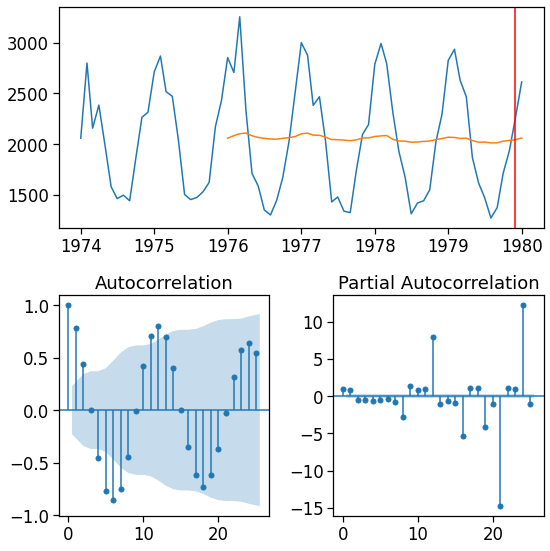

In [82]:
fig = plot_ts(y_pred, lags=25)
fig.axes[0].axvline(df.index[-1], c='red')
pass

## Bayesian modeling with `prophet`

In [83]:
! python3 -m pip install --quiet fbprophet

In [84]:
from fbprophet import Prophet

Data needs to have just two columns `ds` and `y`.

In [85]:
data = df.reset_index()

In [86]:
m7 = Prophet()

In [87]:
m7 = m7.fit(data)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#### Making forecasts

In [88]:
future = m7.make_future_dataframe(periods=24, freq='M')

In [89]:
forecast = m7.predict(future)

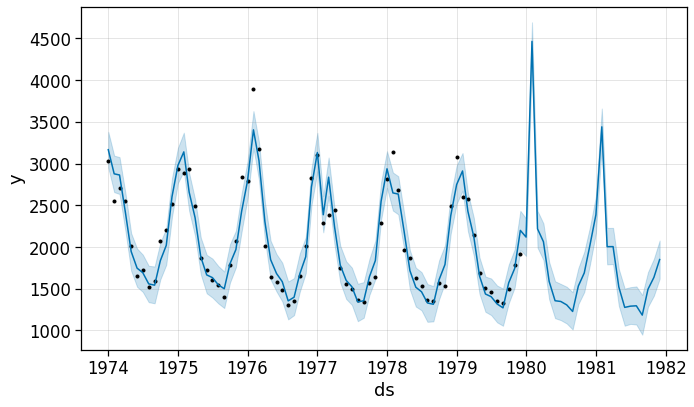

In [90]:
m7.plot(forecast)
pass

## Model evaluation

### Similarity measures

There are several measures commonly used to evaluate the quality of forecasts. The are the same measures we use to evaluate the fit to any function such as$R^2$, MSE and MAE, so will not be described further here. 

### Cross-validation

From https://cdn-images-1.medium.com/max/800/1*6ujHlGolRTGvspeUDRe1EA.png

![img](https://cdn-images-1.medium.com/max/800/1*6ujHlGolRTGvspeUDRe1EA.png)

In [91]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [92]:
tsp = TimeSeriesSplit(n_splits=3)

In [93]:
for train, test in tsp.split(df):
    print(train.shape, test.shape)

(18,) (18,)
(36,) (18,)
(54,) (18,)


In [94]:
df.index[train[-1]]

Timestamp('1978-06-01 00:00:00', freq='MS')

In [95]:
df.index[train[-1]+len(test)]

Timestamp('1979-12-01 00:00:00', freq='MS')

#### A routine like the following can be used for model comparison

In [96]:
res = []
for train, test in tsp.split(df):
    m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    m.fit(data.iloc[train])
    future = data[['ds']].iloc[test]
    y_pred = m.predict(future).yhat
    y_true = data.y[test]
    res.append(mean_squared_error(y_true, y_pred))

INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


In [97]:
np.mean(res)

389145.04484811745

#### If you are using `prophet` it includees its own [diagnostic functions](https://facebook.github.io/prophet/docs/diagnostics.html)

Prophet is oriented for daily data. At present, it does not appear to support cross-validation for monthly data.